In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.linear_model import LinearRegression

2023-02-07 09:55:47.339408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 09:55:47.792517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-07 09:55:47.792563: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-07 09:55:49.398513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
X_train = np.load(os.path.join('assets', 'X_train_surge_new.npz'))
Y_train = pd.read_csv(os.path.join('assets', 'Y_train_surge.csv'))
X_test = np.load(os.path.join('assets', 'X_test_surge_new.npz'))

In [3]:
x_surge1 = X_train['surge1_input']  # (5599, 10)
x_surge2 = X_train['surge2_input']  # (5599, 10)

x_surge1_times = X_train['t_surge1_input']  # (5599, 10)
x_surge2_times = X_train['t_surge2_input']  # (5599, 10)

x_surge_ids = X_train['id_sequence']

# x_slp = X_train['slp']       # (5599, 40, 41, 41)
# x_slp = x_slp[:, ::4, :, :]  # (5599, 10, 41, 41)

y_surge1 = np.array([Y_train[f'surge1_t{i}'] for i in range(10)]).T  # (5599, 10)
y_surge2 = np.array([Y_train[f'surge2_t{i}'] for i in range(10)]).T  # (5599, 10)

y_surge_ids = Y_train['id_sequence'].values

y_surge1_expected_times = X_train['t_surge1_output']
y_surge2_expected_times = X_train['t_surge2_output']

print(x_surge1.shape, y_surge1.shape)
print(x_surge_ids, y_surge_ids)

print


(5599, 10) (5599, 10)
[   1    2    3 ... 5597 5598 5599] [   1    2    3 ... 5597 5598 5599]


In [135]:
# create input and output data
X = []
Y = []

for (x1, x2, y1, y2) in zip(x_surge1, x_surge2, y_surge1, y_surge2):
  X.append(x1)
  Y.append(y1)

# create train and test data
X_train, X_test = np.array(X[:5500]), np.array(X[5500:])
Y_train, Y_test = np.array(Y[:5500]), np.array(Y[5500:])

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5500, 10) (5500, 10)
(99, 10) (99, 10)


In [ ]:
#créer un objet reg Lin
modele=LinearRegression()

#créer y et X
y=x_surge1[:100].reshape(-1,)
print(y.shape)
X=data_im


liste=np.empty([1000,2])

print(liste.shape)
for k in range(1000):
    for i in range(10):
        liste[k]=data_im[k][i]
X=liste
print(y.shape)
print(X.shape)
modele.fit(X,y)
print(modele.score(X,y))
predictions=modele.predict(X)

for k in range(100):
    print(X[k])



#print(preditions)
#print(y)

plt.plot(X,y,'.',c='r')
plt.show()
plt.plot(X,predictions, '.', c='b')
plt.show()
plt.plot(X[1],y,'.',c='r')
plt.show()
plt.plot(X[1],predictions, '.', c='b')
plt.show()

(5500, 9)
(5500, 1)
0.6093582607490124


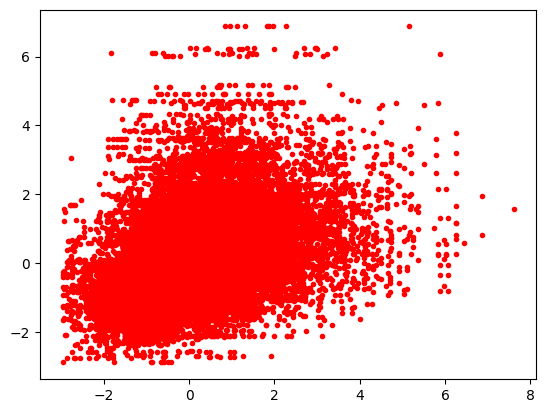

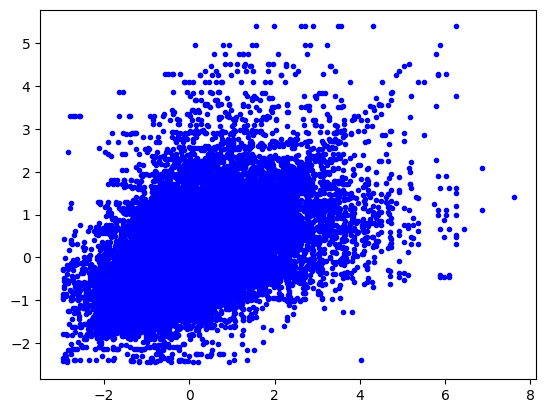

In [137]:
#créer un objet reg Lin
modele=LinearRegression()

nb_jour=5500
#créer y et X
y=np.zeros([nb_jour,1])

liste=np.zeros([nb_jour,9])


for i in range(nb_jour):
    y[i]=x_surge1[i][9]
    for j in range(9):
        liste[i][j]=x_surge1[i][j]

X=liste
print(X.shape)
print(y.shape)
modele.fit(X,y)
print(modele.score(X,y))
predictions=modele.predict(X)

#print(preditions)
#print(y)

plt.plot(X,y,'.',c='r')
plt.show()
plt.plot(X,predictions, '.', c='b')
plt.show()

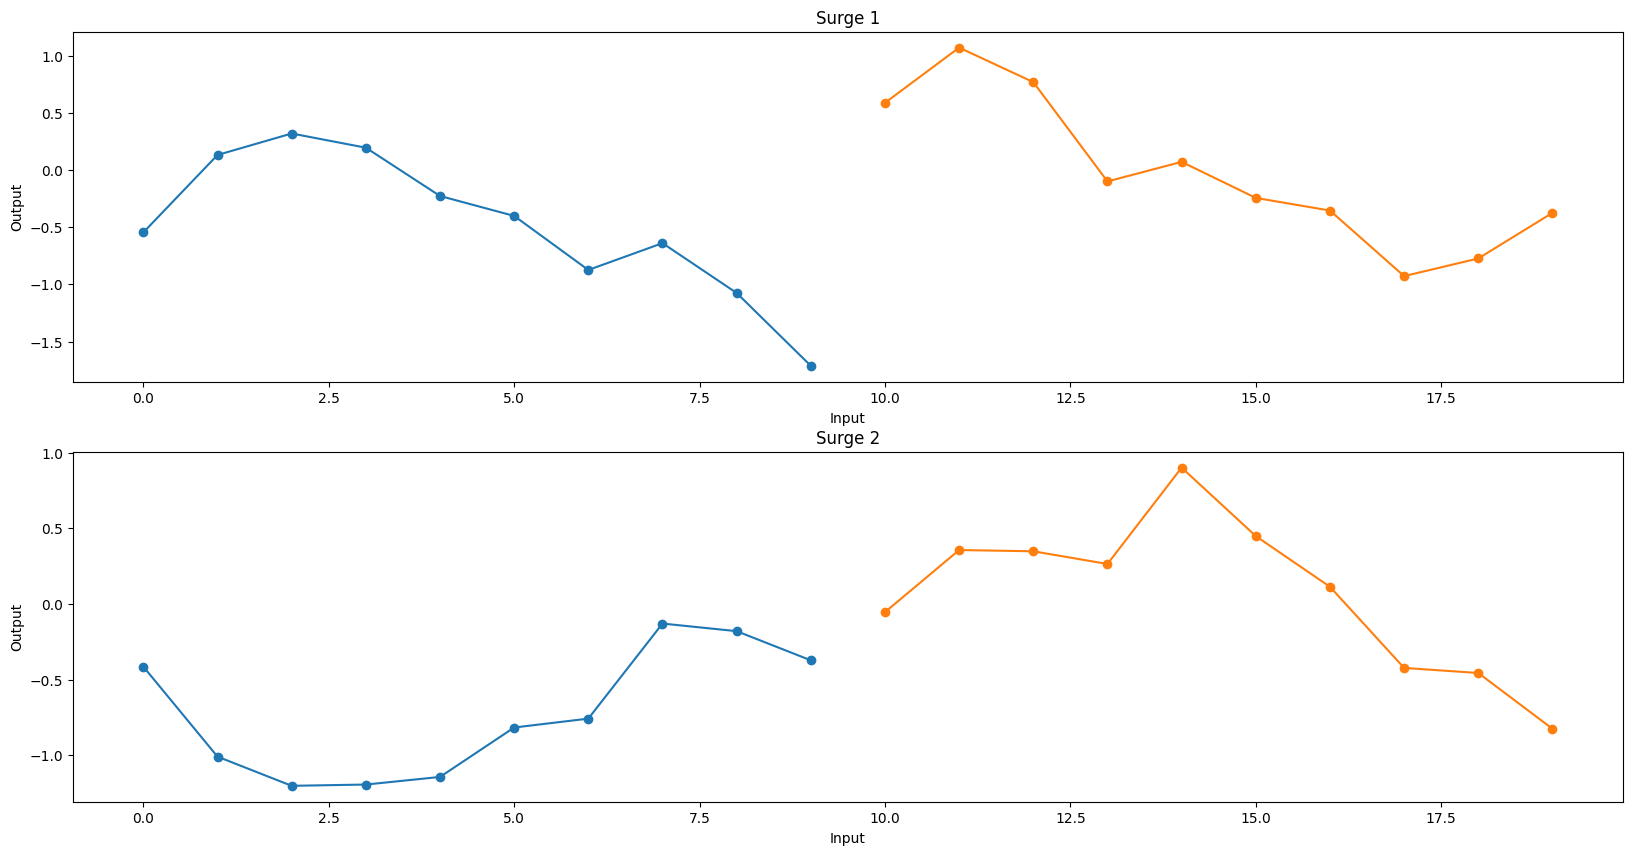

In [133]:
idx = 0

# display (x_surge1, y_surge1) and (x_surge2, y_surge2) in a single plot
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(range(10), x_surge1[idx], 'o-')
ax[0].plot(range(10, 20), y_surge1[idx], 'o-')
ax[0].set_title('Surge 1')
ax[0].set_xlabel('Input')
ax[0].set_ylabel('Output')
ax[1].plot(range(10), x_surge2[idx], 'o-')
ax[1].plot(range(10, 20), y_surge2[idx], 'o-')
ax[1].set_title('Surge 2')
ax[1].set_xlabel('Input')
ax[1].set_ylabel('Output')
plt.show()

(99, 10)
(20, 20)
(99, 10)


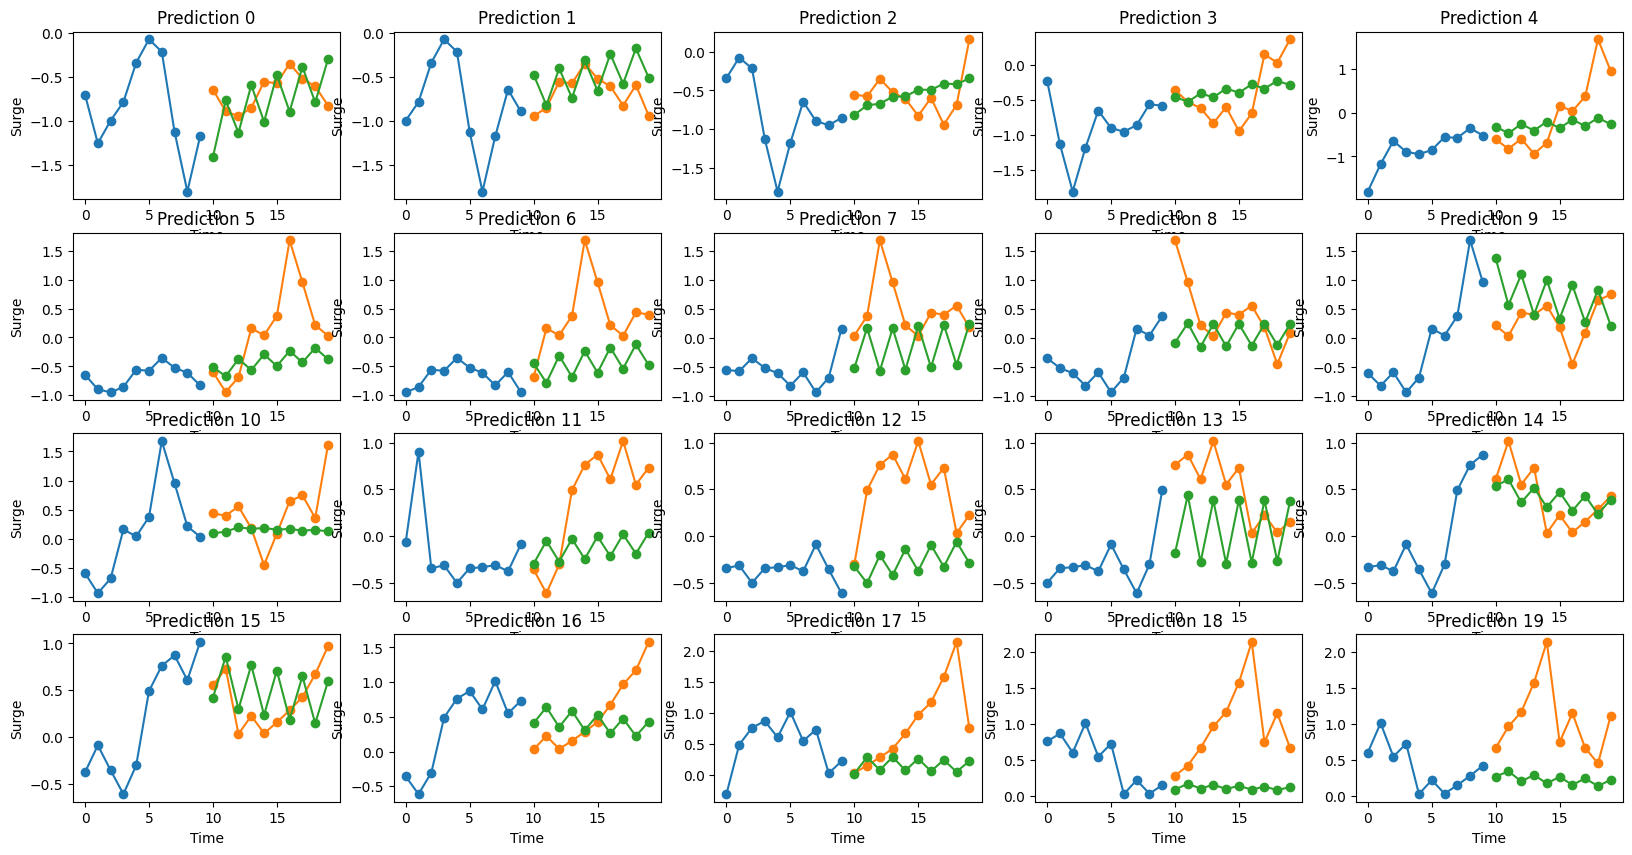

In [140]:
# make predictions
print(X_test.shape)
nb_jour=20
Y_pred=np.zeros([nb_jour,20])

for k in range(nb_jour):
  for i in range(10):
    Y_pred[k][i]=X_test[k][i]
  for i in range(10):
    prediction = modele.predict([Y_pred[k,i:i+9]])
    Y_pred[k][i+10]=prediction[0][0]
  
print(Y_pred.shape)

print(Y_test.shape)

# plot predictions
fig, ax = plt.subplots(4, 5, figsize=(20, 10))

for i in range(4):
  for j in range(5):
    idx = i * 5 + j
    ax[i, j].plot(range(10), X_test[idx], 'o-')
    ax[i, j].plot(range(10, 20), Y_test[idx], 'o-')
    ax[i, j].plot(range(10, 20), Y_pred[idx,10:20], 'o-')
    ax[i, j].set_title(f'Prediction {idx}')
    ax[i, j].set_xlabel('Time')
    ax[i, j].set_ylabel('Surge')
plt.show()  # predictions are not good

In [ ]:

#créer un objet reg Lin
modele=LinearRegression()
nb_jour=300
#créer y et X
list_var=X_train.files

y=x_surge1[:nb_jour].reshape(-1,1)

liste=np.zeros([nb_jour*10,41*41])

#print(liste.shape)
m=100000.0
for i in range(nb_jour*10): #Change
    for k in range(10):
        liste[i]=x_slp[i][k].reshape(-1,)
print(liste.min())
X=liste
print(X.shape)
print(y.shape)

modele.fit(X,y)
print(modele.score(X,y))
predictions=modele.predict(X)

print(predictions)
print(y)
print(X.min())
plt.plot(X,y,'.',c='r')
plt.show()

plt.plot(X,predictions, '.',c='b')
plt.show()



In [ ]:
# make predictions
Y_pred = model.predict(X_test)

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
 
# plot predictions
plt.plot(Y_test[:, 0], label='actual')
plt.plot(Y_pred[:, 0], label='predicted')
plt.legend()
plt.show()

In [107]:
import surge_prediction_metric as surge

# convert predictions to dataframe
Y_pred_df = pd.DataFrame(Y_pred, columns=[f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)])
Y_true_df = pd.DataFrame(Y_test, columns=[f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)])

s1 = surge.surge_prediction_metric(Y_true_df[:10], Y_pred_df[:10])
s2 = surge.surge_prediction_metric(Y_true_df[10:], Y_pred_df[10:])
print(s1, s2)

ValueError: Shape of passed values is (1198, 10), indices imply (1198, 20)